# Lab 4 - Linear models

## Mateusz Floras

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [68]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [69]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [70]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

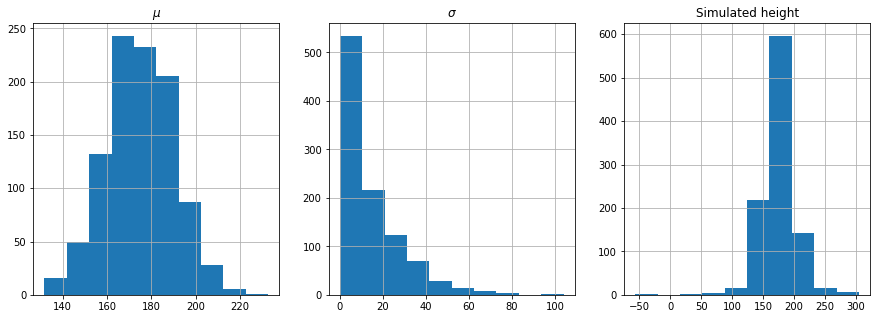

In [71]:
mu = sim.stan_variable("mu")
sigma = sim.stan_variable("sigma")
height = sim.stan_variable("height")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(mu)
axs[0].set_title(r"$\mu$")
axs[0].grid()

axs[1].hist(sigma)
axs[1].set_title(r"$\sigma$")
axs[1].grid()

axs[2].hist(height)
axs[2].set_title(r"Simulated height")
axs[2].grid()

plt.show()

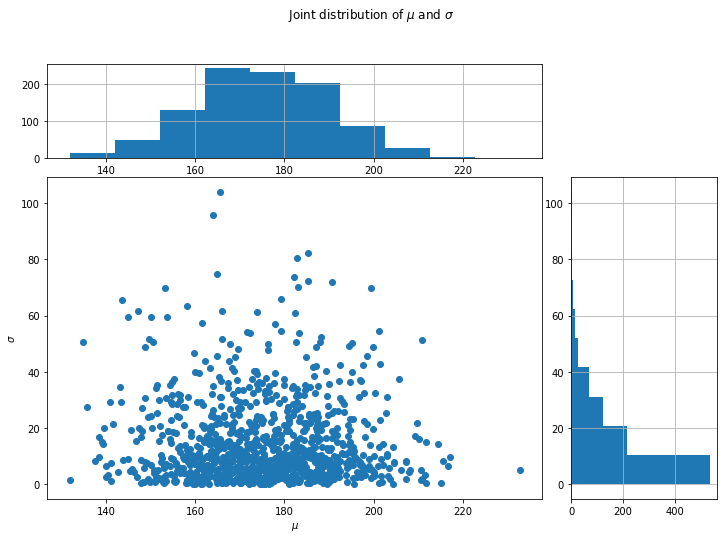

In [72]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 8))
fig.suptitle(r'Joint distribution of $\mu$ and $\sigma$')
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_scatter.set_xlabel(r'$\mu$')
ax_scatter.set_ylabel(r'$\sigma$')
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(mu, sigma)

ax_hist_x.hist(mu)
ax_hist_x.grid()
ax_hist_y.hist(sigma, orientation = 'horizontal')
ax_hist_y.grid()

plt.show()

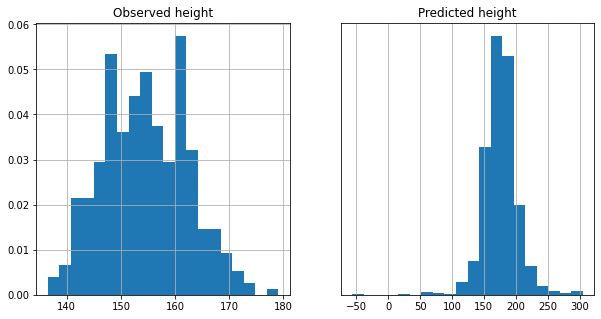

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(d.height, bins=20, density=True)
axs[0].set_title("Observed height")
axs[0].grid()

axs[1].hist(height, bins=20, density=True)
axs[1].set_title("Predicted height")
axs[1].set_yticks(())
axs[1].grid()

plt.show()

Above histograms show that there are a lot of differences between observed and predicted height, so it is impossible to receive exact or even similar data using priors.

## Task 2. Model fit and evaluation

In [74]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [75]:
fit=model_1_fit.sample(data=dict(N=len(d),
                        heights=d.height.values),
                        seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


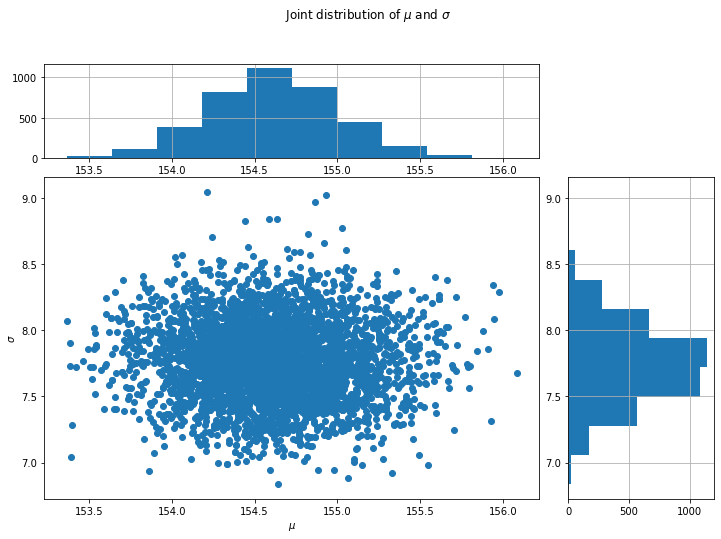

In [76]:
mu = fit.stan_variable("mu")
sigma = fit.stan_variable("sigma")
height = fit.stan_variable("height")

fig = plt.figure(figsize=(12, 8))

fig.suptitle(r'Joint distribution of $\mu$ and $\sigma$')
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_scatter.set_xlabel(r'$\mu$')
ax_scatter.set_ylabel(r'$\sigma$')
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(mu, sigma)

ax_hist_x.hist(mu)
ax_hist_x.grid()
ax_hist_y.hist(sigma, orientation = 'horizontal')
ax_hist_y.grid()

plt.show()

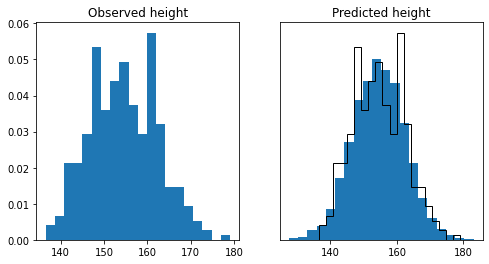

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(d.height, bins=20, density=True)
axs[0].set_title("Observed height")

axs[1].hist(height, bins=20, density=True)
axs[1].set_title("Predicted height")
axs[1].set_yticks(())
axs[1].hist(d.height,bins=20,histtype='step',color='black',density=True)


plt.show()

The quality of the model is definitely better than the previous one. As we can in the second histogram, observed and predicted data are very similar.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [78]:
d["c_weight"] = d.weight.mean() - d.weight
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
d.head()


,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,-2.835121
1,139.700,36.485807,63.0,0,8.504679
2,136.525,31.864838,65.0,0,13.125648
3,156.845,53.041914,41.0,1,-8.051429
4,145.415,41.276872,51.0,0,3.713614


## Task 4. Prior predictive checks
 

In [79]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [80]:
sim_df = sim.draws_pd()
sim_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,215.623,7.771810,23.208300,78.6749,48.5306,91.5528,118.723,148.5400,...,305.220,326.9950,324.0880,299.4560,266.4000,291.0510,302.2970,331.4010,325.3600,338.7390
1,0.0,0.0,157.016,-0.067795,0.086958,158.3420,158.2580,158.2130,158.207,158.1650,...,156.702,156.4240,156.3030,156.3240,156.2100,156.2940,156.1140,156.1520,156.2300,156.0660
2,0.0,0.0,168.595,-11.386400,20.358900,402.4120,362.3250,355.4750,363.641,351.9230,...,112.466,42.4608,92.8373,61.4541,87.0594,39.9763,52.6142,34.0803,16.7095,14.4496
3,0.0,0.0,160.268,-2.544520,6.415610,214.6010,200.1840,201.3620,194.985,198.0280,...,143.352,139.1050,138.9670,144.0020,130.3170,128.4050,135.5500,125.0930,129.1100,122.5630
4,0.0,0.0,160.098,16.710200,9.955320,-166.7060,-135.7210,-126.7510,-115.765,-84.2886,...,310.371,318.6570,309.2170,329.1550,336.8950,344.6620,354.7480,378.4680,387.5360,384.5930


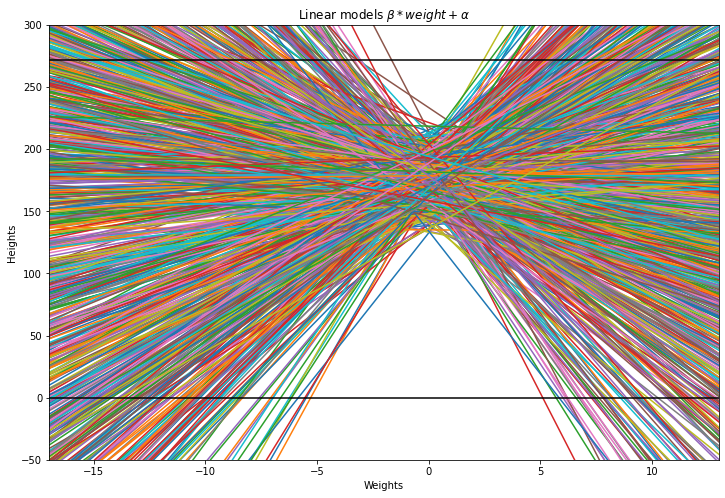

In [81]:
min_weight = d.c_weight.min()
max_weight = d.c_weight.max()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([min_weight, max_weight], [sim_df["alpha"]+sim_df["beta"]*min_weight, sim_df["alpha"]+sim_df["beta"]*max_weight])
ax.set_ylim([-50, 300])
ax.set_xlim([-17, 13])
ax.axhline(y=0, color='k')
ax.axhline(y=272, color='k')
ax.set_title(r'Linear models $\beta*weight+\alpha$')
ax.set_xlabel("Weights")
ax.set_ylabel("Heights")

plt.show()


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

As we can see in the above plot, there are only few lines between minimum and maximum height. The most of lines can't fit to area betwwen defined limits.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [82]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [83]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

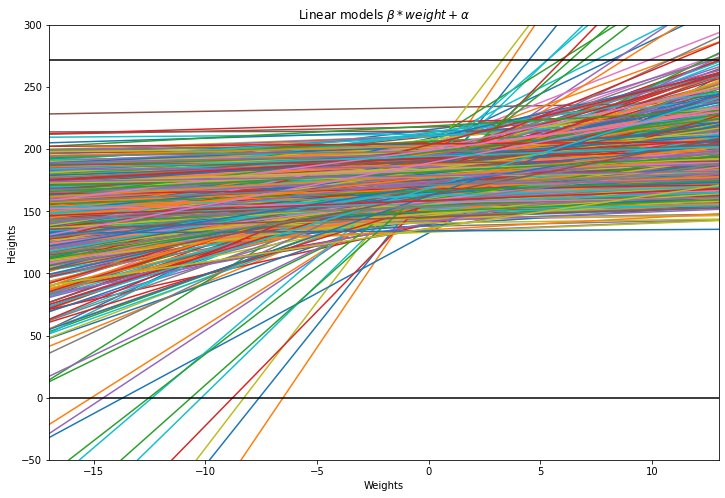

In [84]:
sim_df = sim.draws_pd()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([min_weight, max_weight], [sim_df["alpha"]+sim_df["beta"]*min_weight, sim_df["alpha"]+sim_df["beta"]*max_weight])
ax.set_ylim([-50, 300])
ax.set_xlim([-17, 13])
ax.axhline(y=0, color='k')
ax.axhline(y=272, color='k')
ax.set_title(r'Linear models $\beta*weight+\alpha$')
ax.set_xlabel("Weights")
ax.set_ylabel("Heights")
plt.show()

For the lognormal distribution the result is definitely better. The most of lines are inside the area between definied minimum and maximum.

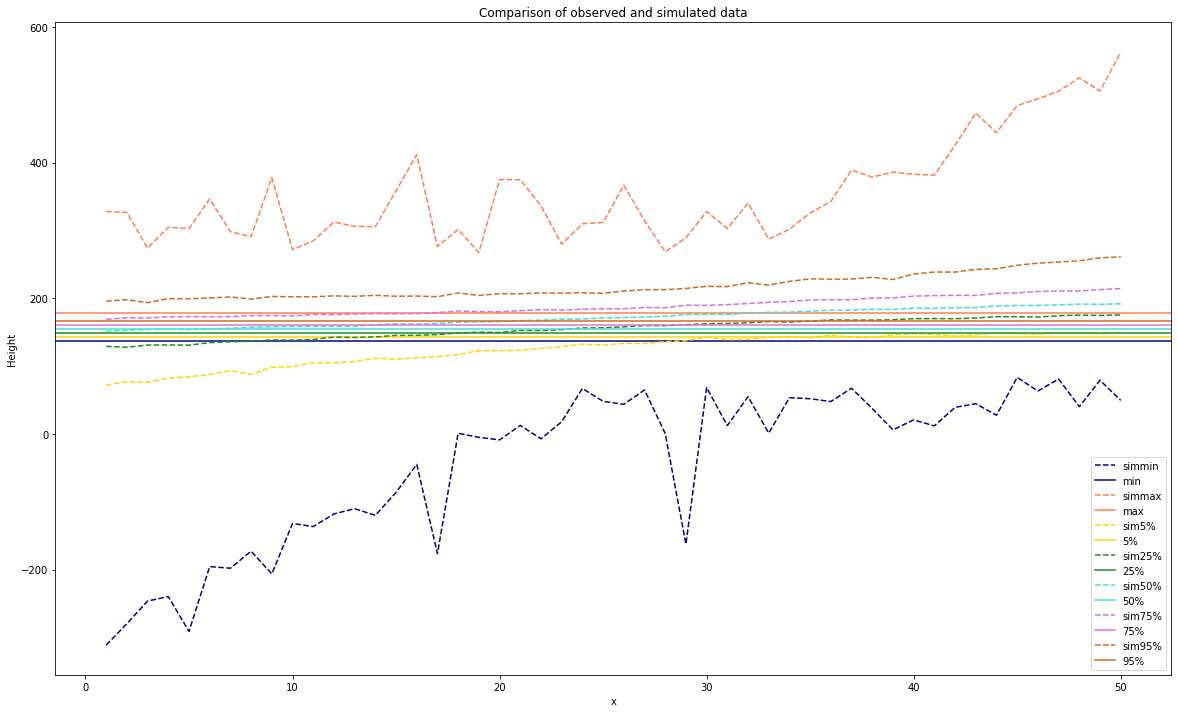

In [85]:
sim_stats_data = sim_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
statistics = ["min", "max", "5%", "25%", "50%", "75%", "95%"]
colors = ["darkblue", "coral", "gold", "forestgreen", "turquoise", "orchid", "chocolate"]

stats_data = d.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])["height"]

fig, ax = plt.subplots(figsize=(20, 12))
x = np.linspace(1, 50)

for stat, color in zip(statistics, colors):
    ax.plot(x, sim_stats_data.loc[[stat]].iloc[:, 5:].values.T, "--", label="sim" + stat, color=color)
    ax.axhline(y=stats_data.loc[[stat]].iloc[0], label=stat, color=color)

ax.set_xlabel('x')
ax.set_ylabel('Height')
ax.set_title('Comparison of observed and simulated data')

plt.legend()
plt.show()


Simulated data is defnitely more spreaded out but observed data is possible within prior model.

## Task 6. Fitting and evaluating model


In [86]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [87]:
N=50
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


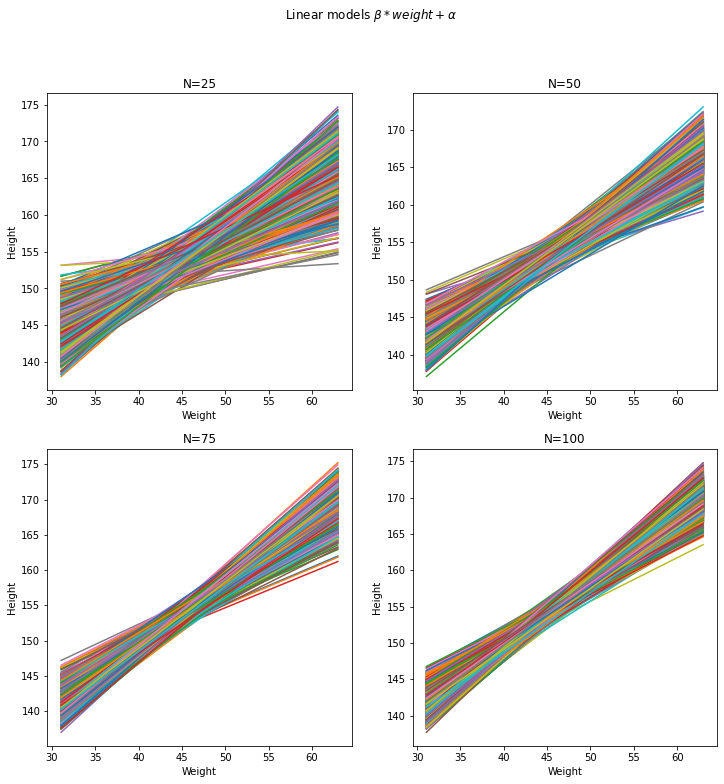

In [88]:
N_samples = [25, 50, 75, 100]

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(r'Linear models $\beta*weight+\alpha$')

for sample in range(len(N_samples)):
    N = N_samples[sample]
    data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    row = sample // 2
    col = sample % 2
    ax[row, col].plot([d.weight.min(),d.weight.max()],[df["alpha"]+df["beta"]*d.weight.min(), df["alpha"]+df["beta"]*d.weight.max()])
    ax[row, col].set_title("N={0}".format(N))
    ax[row, col].set_xlabel("Weight")
    ax[row, col].set_ylabel("Height")

plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


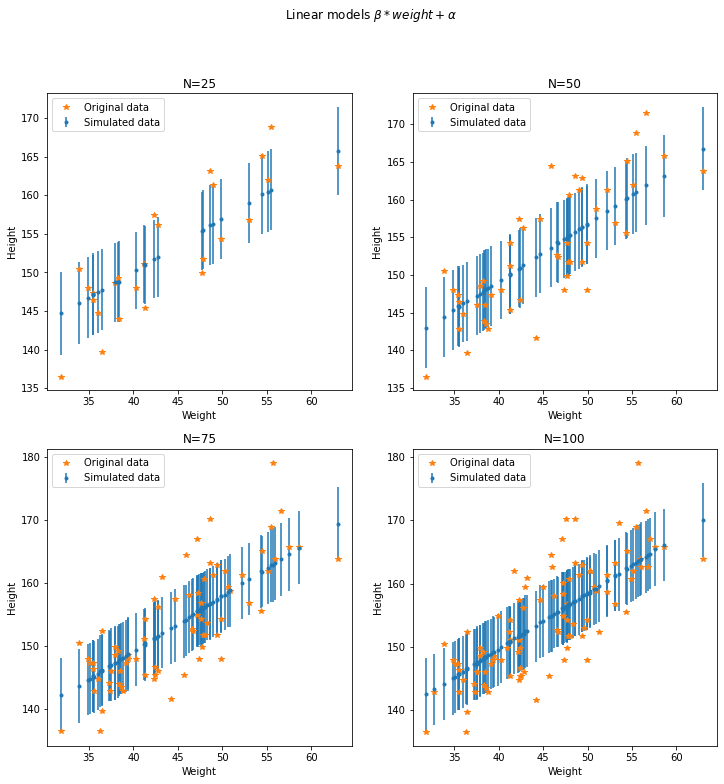

In [89]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(r'Linear models $\beta*weight+\alpha$')

for sample in range(len(N_samples)):
    N = N_samples[sample]
    data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
    fit_model=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit_model.draws_pd().describe()
    row = sample // 2
    col = sample % 2
    ax[row, col].errorbar(d.weight.iloc[:N].values,df.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=df.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
    ax[row, col].plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
    ax[row, col].set_title("N={0}".format(N))
    ax[row, col].set_xlabel("Weight")
    ax[row, col].set_ylabel("Height")
    ax[row, col].legend()

plt.show()

For greater amount of samples, efficiency of the model is better. 

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


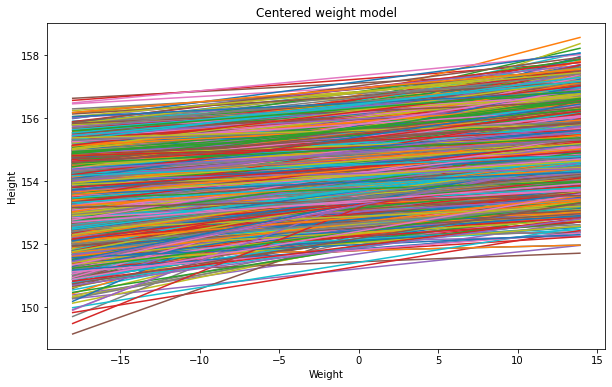

In [90]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')
N = 100
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([d.c_weight.min(),d.c_weight.max()],[df["alpha"]+df["beta"]*d.c_weight.min(), df["alpha"]+df["beta"]*d.c_weight.max()])
ax.set_title("Centered weight model")
ax.set_xlabel("Weight")
ax.set_ylabel("Height")

plt.show()

In [91]:
model_3_ppc=CmdStanModel(stan_file='height_3_ppc.stan')

R=1000
data_sim = data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim = model_3_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

df = sim.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


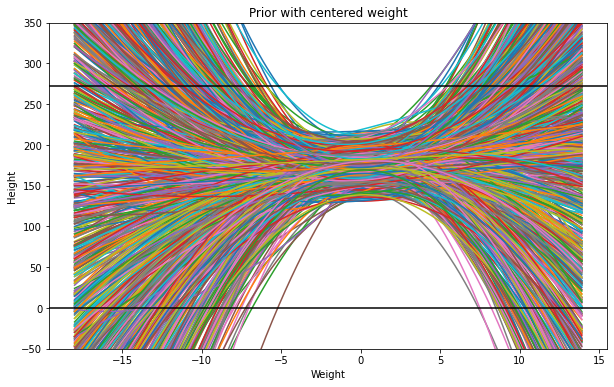

In [92]:
size = 1000
x = np.linspace(d.c_weight.min(), d.c_weight.max(), size)

fig, ax = plt.subplots(figsize=(10,6))
for i in range(size):
    ax.plot(x, df["alpha"][i]+df["beta"][i]*x+df["beta2"][i]*(x**2))

ax.axhline(y=272, color='k')
ax.axhline(y=0, color='k')
ax.set_title("Prior with centered weight")
ax.set_xlabel("Weight")
ax.set_ylabel("Height")
ax.set_ylim([-50, 350])

plt.show()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Samp


INFO:cmdstanpy:CmdStan done processing.


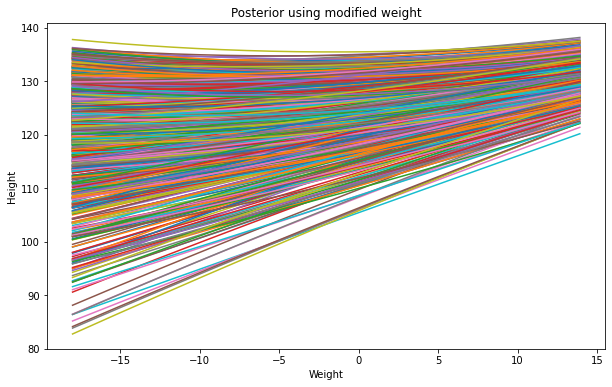

In [93]:
model_3_fit=CmdStanModel(stan_file='height_3_fit.stan')
N = 100
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_3_fit.sample(data=data_fit,seed=28052020)

df = fit.draws_pd()

figure, ax = plt.subplots(figsize=(10,6))
for i in range(1000):
    ax.plot(x, df["alpha"][i]+df["beta"][i]*x+df["beta2"][i]*(x**2))
ax.set_title("Posterior using modified weight")
ax.set_xlabel("Weight")
ax.set_ylabel("Height")

plt.show()



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampl


INFO:cmdstanpy:CmdStan done processing.


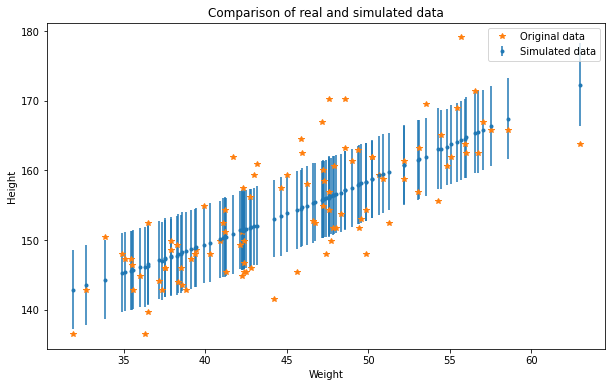

In [94]:
model_3_fit=CmdStanModel(stan_file='height_3_fit.stan')
N = 100
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_3_fit.sample(data=data_fit,seed=28052020)

df = fit.draws_pd().describe()

figure, ax = plt.subplots(figsize=(10,6))
ax.errorbar(d.weight.iloc[:N].values,df.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=df.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
ax.plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
ax.legend()
ax.set_title("Comparison of real and simulated data")
ax.set_xlabel("Weight")
ax.set_ylabel("Height")

plt.show()

After fitting the model, it is still good.